<a href="https://colab.research.google.com/github/PedroPinheiroMachado/Portfolio/blob/main/ChurnPredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ideia do Projeto

O contexto inicial se dá em uma empresa na qual fornece algum tipo de seriço, por exemplo: Netflix.

É interessante para essas empresas, manter os usuários que já possuem uma assinatura, assim nasce o *Churn rate* ou simplesmente *Churn*.

*Churn* nada mais é a taxa de clientes que foram perdidos no período de tempo observado.

Sua importância fica ainda mais evidente uma vez que, o Custo de Aquisição de Cliente (CAC) tende a ser maior do que o custo para manter.

Assim, fica evidente que é interessante saber qual cliente está incliando a cancelar o serviço, nosso desafio então, é descobrir quais clientes são.

##Aquisição dos Dados

Veja que entendido o problema, fica evidente que são necessários dados de alto valor estratégico. Assim, se tornam dados escassos.

Os dados utilizados neste projeto são originalmente disponibilizados na plataforma de ensino da [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#)

Atualmente podemos encontrar este *dataset* no [link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv), que possui o escopo de uma empresa padrão de telecomunicações

Por mais que ocorra a falta de um dicionário de variáveis, podemos extrair o seu significado por seus nomes.

In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier



path = 'https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Separação Treino e Teste

Como queremos simular fielmente a entrada de novos dados, iremos como primeiro passo, separar nossos dados em conjunto de treino e conjunto de teste.

Como temos por volta de 7000 dados, iremos usar 80% para treino e 20% para teste.

In [428]:
print(f"Possuímos:{df.shape[0]} Clientes")
print(f"Possuímos:{df.shape[1]} Features")

Possuímos:7043 Clientes
Possuímos:21 Features


In [429]:
X = df.drop("Churn", axis =1 )
y= df["Churn"]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=123)

In [430]:
df_treino = pd.concat([X_train, y_train],axis=1)

##Análise Exploratória dos Dados

`customerID`: Id do Cliente

`gender`: Gênero do Cliente (Female ou Male)

`SeniorCitizen`: Se o cliente é idoso (0 ou 1)

`Partner`: Se o cliente possui parceiro (No, Yes)

`Dependents`: Se o cliente possui dependentes (No, Yes)

`tenure`: Número de mêses que o cliente está com a empresa

`PhoneService`: Se possui Serviço de celular (No, Yes)

`MultipleLines` Se possui mais de uma linha de serviço de celular (No PhoneService, No, Yes)

`InternetService`: Se possui internet (No, DSL, Fiber optic)

`OnlineSecurity`:Se possui algum tipo de segurança online (No, Yes, No internet service)

`OnlineBackup`: Se possui algum tipo de serviço capaz de fazer backup online (No, Yes, No internet service)

`DeviceProtection`: Se possui algum tipo de serviço que ofereça proteção dos seus aparelhos (No, Yes, No internet service)

`TechSupport`:Se possui Assistência Técnica (No, Yes, No internet service)

`StreamingTV`: Se possui algum Streaming de TV (No, Yes, No internet service)

`StreamingMovies`:Se possui algum Streaming de Filmes (No, Yes, No internet service)

`Contract`: O tipo de contrato (Month-to-month, One year, Two year)

`PaperlessBilling`: Se o cliente possui cobrança sem papel(No, Yes)

`PaymentMethod`: Método de pagamento (Electronic check, Mailed check, Bank transfer (automatic), credit card (automatic)

`MonthlyCharges`: O quanto é cobrado mensalmente

`TotalCharges`: O quanto foi gasto por cada cliente

`Churn`: Se o cliente fez churn (No, Yes)

Pra cada Variável do *dataset* realizei uma análise rápida de quais eram seus domínios de valores.

A fim de deixar nosso código sucinto, reservei o direito de mostrar apenas 1.

In [431]:
df_treino["gender"].unique()

array(['Male', 'Female'], dtype=object)

###Tratar os tipos das variáveis

Nosso *dataset* não possui nenhum dado não nulo, temos `MonthlyCharges` como único float, `SeniorCitizen`, `tenure`, como int e todas as outras como object.

Percebemos que claramente `SeniorCitizen` e `TotalCharges` estam no tipo errado.


In [432]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 6924 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 1

In [433]:
df_treino["TotalCharges"].value_counts()

,count
TotalCharges,
20.2,10
19.75,9
,8
19.9,7
20.05,6
...,...
1847.55,1
139.35,1
495.15,1


####Resolvendo o problema de TotalCharges

Perceba que temos um problema em `TotalCharges`, temos 11 linhas como " ", primeiramente iremos transformar essas 11 linhas em nulo e depois iremos transformar para float. Uma vez que sem tratar minimamente não conseguimos realizar a transformação.

In [434]:
df_treino["TotalCharges"]= df_treino["TotalCharges"].replace(" ", "NaN")

In [435]:
df_treino["SeniorCitizen"] = df_treino["SeniorCitizen"].astype(object)
df_treino["TotalCharges"] = df_treino["TotalCharges"].astype(float)

In [436]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 6924 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   object 
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 1

Agora temos 8 dados ausentes no nosso *dataset*, poderiamos utilizar técnicas diferentes para resolver esta situação, mas utilizarei o método de substituir pela média de `TotalCharges`.

Como estamos tratando nossos dados na base treino, terei de salvar a média para aplicar como método de pré-processamento no teste.

In [437]:
media = df_treino["TotalCharges"].mean()
df_treino["TotalCharges"]=df_treino["TotalCharges"].fillna(media)
df_treino["TotalCharges"].isna().sum()

np.int64(0)

###Dados Desbalanceados

Podemos ver que Temos um *dataset* desbalanceado, faz sentido, uma vez que é normal manter seus clientes e não é a maioria que irá sair (se fosse assim, deveria revisar de forma completa a empresa e seu serviço oferecido)

Temos um *churn* de `26%`, isso significa que: 28% dos clientes cancelaram o serviço no período estudado.

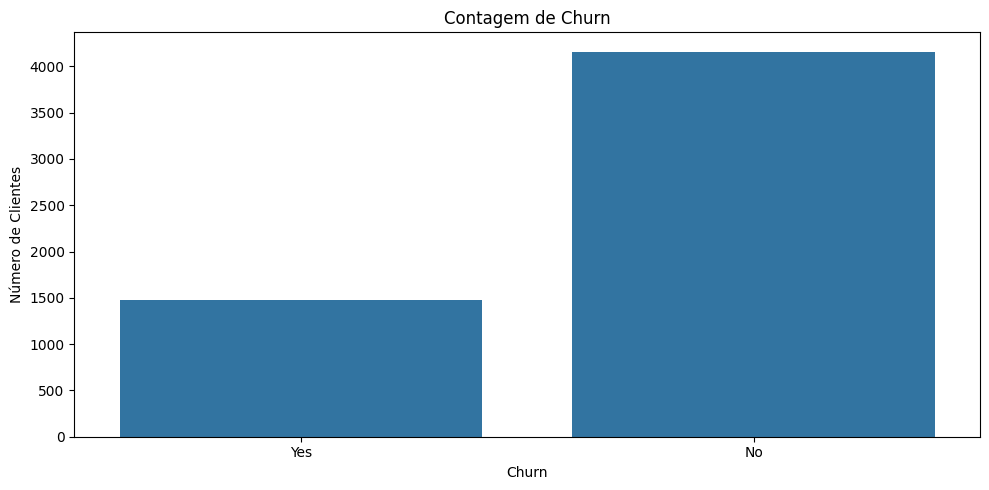

In [414]:
fig, ax = plt.subplots(figsize=(10,5))
countplot = sns.countplot(x="Churn", data=df_treino,ax=ax)
ax.set_title("Contagem de Churn")
ax.set_xlabel("Churn")
ax.set_ylabel("Número de Clientes")
plt.tight_layout()
plt.show()

In [438]:
df_treino["Churn"].value_counts()

,count
Churn,
No,4159
Yes,1475


In [439]:
round(df_treino["Churn"].value_counts()/df_treino.shape[0],2)

,count
Churn,
No,0.74
Yes,0.26


###Entendendo a Correlação das variáveis

Perceba que várias features possuem correlação, por exemplo, pegue `MonthlyCharges`, `TotalCharges`, `tenure`, parece ser bem justo que `MonthlyCharges`*`tenure` = `TotalCharges`

Várias outras possuem um certo nível de dependência, exemplo: `InternetService` e qualquer outro serviço online, uma vez que pra ter o serviço online é necessário ter a internet.



In [440]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 6924 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   object 
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 1

In [441]:
df_internet = df_treino[df_treino["InternetService"]=="No"]

Veja que `PhoneService`, `OnlineSecurity`,`OnlineBackup` `DeviceProtection`, `TechSupport`,`StreamingTV`,`StreamingMovies` Estão definidas,uma vez que não possua serviço de internet, como pensavamos.

In [442]:
df_internet.nunique()

,0
customerID,1226
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,73
PhoneService,1
MultipleLines,2
InternetService,1
OnlineSecurity,1


####Variáveis Numéricas

Podemos ver que `TotalCharges` e `tenure`ja possuem grande correlação, obviamente que nao temos o par `tenure` e `MonthlyCharges` juntos comparados com `TotalCharges`.

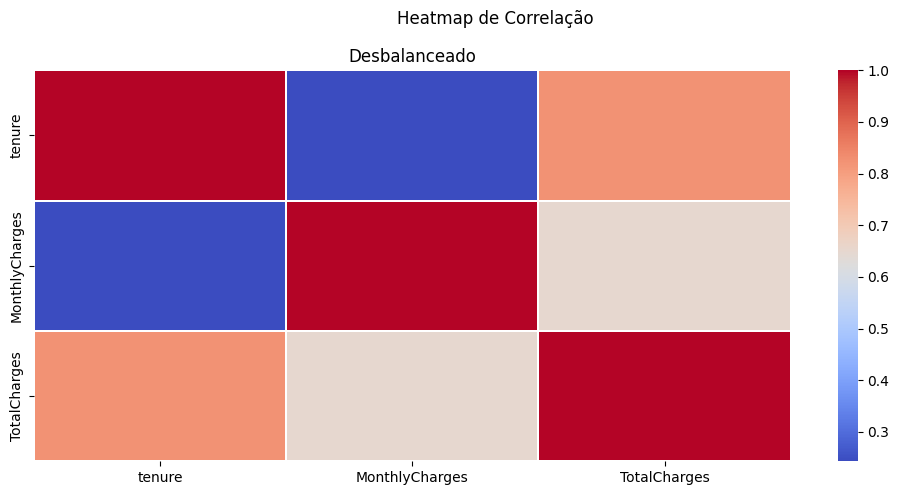

In [443]:
fig,ax = plt.subplots(figsize=(10,5))
corr= df_treino[["tenure","MonthlyCharges","TotalCharges"]].corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax)
fig.suptitle("Heatmap de Correlação")
ax.set_title("Desbalanceado")

plt.tight_layout()
plt.show()



Vemos que tem uma diferença de média -4 unidades.

Como temos poucas features, iremos continuar sem realizar a troca, uma vez que possui divergências de valores.

Se nosso *dataset* possuí-se muitas colunas, realizar a transformação de variáveis seria mais interessante.

In [444]:
df2 = df_treino.copy()

df2["Total"] = df2["tenure"]*df2["MonthlyCharges"]
(df2["Total"]-df2["TotalCharges"]).mean()

np.float64(-3.610489131991645)

####Variávies Categóricas





É evidente que não é possível realizar uma matriz de correlação com valores categóricos, assim utilizaremos o método Cramér's V, não entraremos a fundo como funciona, mas usa a distribuição qui-quadrada para medir a associação entre as variáveis.

Os valores estão entre [0,1] perto de 0 associamento fraco, perto de 1,  forte.

In [445]:
def cramers_v(x, y):
    matriz_corr = pd.crosstab(x, y)
    chi2 = chi2_contingency(matriz_corr)[0]
    n = matriz_corr.sum().sum()
    phi2 = chi2 / n
    r, k = matriz_corr.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

for i in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
  print(cramers_v(df_treino[i],df_treino["InternetService"]),":",i)

print(cramers_v(df_treino["PhoneService"],df_treino["MultipleLines"]))


0.7259025437776624 : OnlineSecurity
0.7071781145516178 : OnlineBackup
0.7071216921497138 : DeviceProtection
0.7222514395437228 : TechSupport
0.7173389309724816 : StreamingTV
0.7171356253143111 : StreamingMovies
1.0


Todos possuem uma associação forte, mas não são números absurdos, não farei nenhuma transformação (nossa base possui apenas 21 colunas).

Resolvi também realizar o teste de `PhoneService` e `MultipleLines`, o teste resultou em um valor de 1, vamos entender melhor.

###Tratando PhoneService e MultipleLines

Como vimos antes, o teste de Cramer's V, resultou que ambos possuem o mesmo significado.

É evidente, observe que `MultipleLines` possui como respotas: "No phone Service": isto já engloba metade dos casos de `PhoneSerice`, "No" e "Yes" que acabam por mapear todos os outros casos.

Assim, `PhoneService` está totalmente englobado em `MultipleLines`.

Como `MultipleLines` possui mais informações, iremos retirar a coluna `PhoneService`.

Não esqueça que devemos fazer isso no teste.

In [446]:
df_treino.drop("PhoneService",axis=1,inplace=True)
df_treino.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

##Preparar os Dados
Neste momento, nosso dado ainda não está pronto para ser cosumido por um modelo de m.l. Temos Variáveis categóricas com mais de 2 classes e Nosso target (`Churn`) está Nominal (Yes, No) e não (0,1).

Veja que nossos dados possuem 3 variáveis numéricas, e cada uma com seu domínio, Neste projeto, usarei o xgboost que tem como base o sistema de arvóres.
É de conhecimento que não se é necessário realizar transformações tais como Normalização ou padronização nestes casos.

Porém como usaremos um boosted tree, podemos ter melhores resultados caso fizermos qualquer tipo de tratamento de escala.

Veja que temos customerID no nosso *dataset*, devemos retirá-lo também

In [447]:
df_treino = df_treino.drop("customerID",axis=1)

In [450]:
# pré processar as variáveis
binary_var = df_treino.nunique()[df_treino.nunique() == 2].keys().tolist()
num_var = [col for col in df_treino.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_treino.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_treino.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var, dtype=int)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6924,1,0,0,0,1,1,69.35,69.35,1,1,...,1,0,0,1,0,0,0,0,1,0
5249,1,0,0,1,72,0,67.20,4671.70,0,0,...,0,0,1,0,0,1,0,1,0,0
5852,1,1,1,0,21,1,69.10,1474.75,1,1,...,1,0,0,1,0,0,0,0,1,0
3597,1,0,1,0,25,1,95.70,2338.35,0,1,...,0,0,1,1,0,0,0,1,0,0
4147,1,1,1,0,71,0,24.85,1901.00,0,0,...,0,1,0,0,0,1,1,0,0,0


A classe positiva é o Yes

##Modelagem dos Dados

Agora iremos modelar finalmente nossos dados, iremos seguir com o modelo xgboost, vale lembrar que nossos dados estão desbalanceados e não realizamos nenhum balanceamento, mas faremos dentro da função do xgboost.

In [451]:
X = df_proc.drop("Churn",axis=1)
y = df_proc["Churn"]

###Otimização dos Hiperparâmetros

Este modelo possui diversos hiperparâmetros, para realizar nosso tunning, iremos separar por partes, caso contrário nossa modelagem poderá demorar muito tempo.

Falta, também, definir qual será a métrica de sucesso para nosso caso. Utilizaremos a curva ROC, uma vez que para churn, entender qual cliente vai sair é importantem, mas, se chutarmos que um cliente está para sair e for mentira, estaremos perdendo dinheiro também.

Vamos otimizar os seguintes parametros em ordem:max_depth, min_child_weight, colsample_bytree, learning_rate

scale_pos_weight usaremos tabelado, sabemos que temos 4159 Neg e 1475 Pos faremos 4159/1475

In [452]:
peso = 4159/1475
modelo = XGBClassifier(scale_pos_weight=peso)

param_grid = {"max_depth":[2,3,4,5,6,7,8,9]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid_search = GridSearchCV(modelo, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X,y)

print("Melhor resultado é {} para o parametro {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor resultado é 0.8421193673831905 para o parametro {'max_depth': 2}


Seguindo a ordem, min_child_weight.

Está fixo o scale_pos_weight = 4159/1475 e max_depth=2

In [453]:
peso = 4159/1475
modelo = XGBClassifier(scale_pos_weight=peso, max_depth=2)

param_grid = {"min_child_weight":[0.1,1,3,6,7]
}

kfold= StratifiedKFold(n_splits=10, shuffle = True, random_state=123)
grid_search = GridSearchCV(modelo, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X,y)

print("Melhor resultado é {} para o parametro {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor resultado é 0.842962718712369 para o parametro {'min_child_weight': 0.1}


Seguindo, temos: scale_pos_weight = 4159/1475, max_depth=2, min_child_weight=0.1

Faremos agora para colsample_bytree.

In [454]:
peso=4159/1475
model = XGBClassifier(scale_pos_weight=peso, max_depth=2, min_child_weight=0.1)

param_grid = {"colsample_bytree":[0.01,0.2,0.3,0.5]
}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1,cv=kfold)
grid_result = grid_search.fit(X,y)

print("Melhor resultado é {} para o parâmetro {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor resultado é 0.8449420832514368 para o parâmetro {'colsample_bytree': 0.3}


Seguindo, temos: scale_pos_weight = 4159/1475, max_depth=2, min_child_weight=0.1, colsample_bytree=0.3

Faremos agora para, para finalizar, learning_rate.

In [455]:
peso=4159/1475
model = XGBClassifier(scale_pos_weight=peso, max_depth=2, min_child_weight=0.1, colsample_bytree=0.3)

param_grid = {"learning_rate":[0.01,0.1,0.2,0.3,0.8]
}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1,cv=kfold)
grid_result = grid_search.fit(X,y)

print("Melhor resultado é {} para o parâmetro {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor resultado é 0.846365585437767 para o parâmetro {'learning_rate': 0.2}


Então temos nosso modelo feito com A melhor métrica de 0.846 (Área Embaixo da Curva)



##Aplicando no Conjunto de Testes

Como queremos simular fielmente a entrada de novos dados, nosso conjunto de testes está sem nenhuma alteração, isto é, os tipos dos dados, o tratamento do vlaor nulo, criação de dummies...

Assim devemos aplicar os métodos de preprocessamentos já feitos agora.

In [456]:
df_teste = pd.concat([X_test, y_test],axis=1)

###Aplicar o Preprocessamento

Veja que temos os problemas passados, `TotalCharges` como object, `SeniorCitize`como int

In [457]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 941 to 3266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1409 non-null   object 
 1   gender            1409 non-null   object 
 2   SeniorCitizen     1409 non-null   int64  
 3   Partner           1409 non-null   object 
 4   Dependents        1409 non-null   object 
 5   tenure            1409 non-null   int64  
 6   PhoneService      1409 non-null   object 
 7   MultipleLines     1409 non-null   object 
 8   InternetService   1409 non-null   object 
 9   OnlineSecurity    1409 non-null   object 
 10  OnlineBackup      1409 non-null   object 
 11  DeviceProtection  1409 non-null   object 
 12  TechSupport       1409 non-null   object 
 13  StreamingTV       1409 non-null   object 
 14  StreamingMovies   1409 non-null   object 
 15  Contract          1409 non-null   object 
 16  PaperlessBilling  1409 non-null   object 
 17

In [458]:
df_teste = df_teste.replace(" ", "NaN")
df_teste["SeniorCitizen"] = df_teste["SeniorCitizen"].astype(object)
df_teste["TotalCharges"] = df_teste["TotalCharges"].astype(float)

Agora devemos substituir os valores NaN com  a média já calcuada

In [459]:
df_teste["TotalCharges"] = df_teste["TotalCharges"].fillna(media)

In [460]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 941 to 3266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1409 non-null   object 
 1   gender            1409 non-null   object 
 2   SeniorCitizen     1409 non-null   object 
 3   Partner           1409 non-null   object 
 4   Dependents        1409 non-null   object 
 5   tenure            1409 non-null   int64  
 6   PhoneService      1409 non-null   object 
 7   MultipleLines     1409 non-null   object 
 8   InternetService   1409 non-null   object 
 9   OnlineSecurity    1409 non-null   object 
 10  OnlineBackup      1409 non-null   object 
 11  DeviceProtection  1409 non-null   object 
 12  TechSupport       1409 non-null   object 
 13  StreamingTV       1409 non-null   object 
 14  StreamingMovies   1409 non-null   object 
 15  Contract          1409 non-null   object 
 16  PaperlessBilling  1409 non-null   object 
 17

Também fizemos o drop de `PhoneService` e `customerID`

In [461]:
df_teste = df_teste.drop("PhoneService",axis=1)
df_teste = df_teste.drop("customerID",axis=1)

Agora iremos preparar os dados, temos que aplicar dummie nas categóricas >2

In [462]:
# pré processar as variáveis
binary_var = df_teste.nunique()[df_teste.nunique() == 2].keys().tolist()
num_var = [col for col in df_teste.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_teste.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_teste[i] = le.fit_transform(df_teste[i])

# Encoding para colunas categóricas com múltiplas classes
df_teste = pd.get_dummies(df_teste, columns=cat_var,dtype=int)

# ver as 5 primeiras entradas do novo dataframe
df_teste.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
941,0,0,0,1,13,0,30.15,382.20,0,0,...,1,0,0,1,0,0,0,0,1,0
1404,0,0,0,0,35,0,23.30,797.10,0,0,...,0,1,0,0,0,1,1,0,0,0
5515,0,0,1,1,18,0,19.35,309.25,0,1,...,0,1,0,0,0,1,0,0,0,1
3684,1,0,0,0,43,1,75.35,3161.40,0,0,...,1,0,0,1,0,0,0,1,0,0
7017,0,0,0,0,51,0,20.65,1020.75,0,1,...,0,1,0,0,0,1,1,0,0,0


Finalmente Podemos aplicar nosso modelo no nosso conjunto de testes

In [463]:
X_test = df_teste.drop("Churn",axis=1)
y_test = df_teste["Churn"]

Nosso modelo final será feito usando (scale_pos_weight=peso, max_depth=2, min_child_weight=0.1, colsample_bytree=0.3, learning_rate=0.2)

In [464]:
modelo = XGBClassifier(scale_pos_weight=peso, max_depth=2, min_child_weight=0.1, colsample_bytree=0.3, learning_rate=0.2)

modelo.fit(X,y)

y_pred = modelo.predict(X_test)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1015
           1       0.55      0.81      0.66       394

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.81      0.76      0.77      1409

AUC: 0.7768



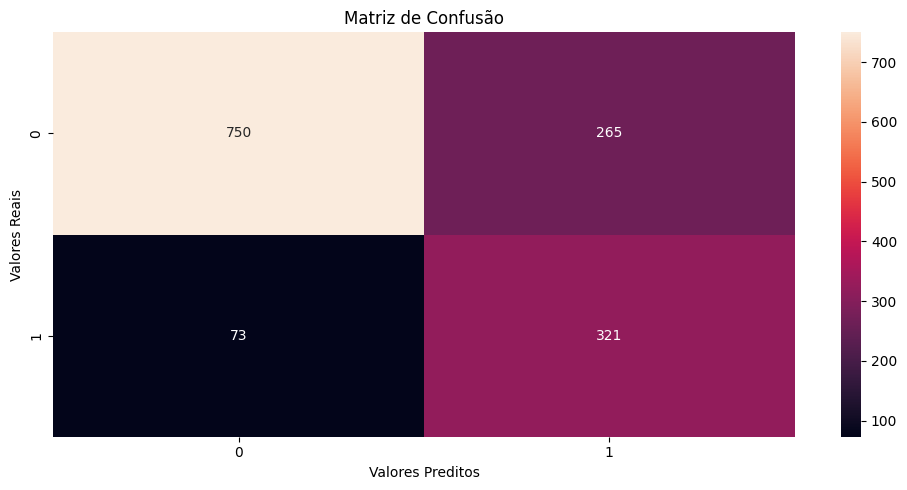

In [466]:
# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

fig, ax = plt.subplots(figsize=(10,5))

matriz_conf = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_conf, annot=True, fmt='g',ax=ax)
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Valores Preditos")
ax.set_ylabel("Valores Reais")
plt.tight_layout()
plt.show()

##Resultados

Nosso Teste foi um pouco pior do que esperado, AUC: 0.7768. Melhor modelo de treino teve AUC: 0.846

Mas é esperado uma vez que são dados completamente novos.

Nosso modelo foi muito bom em predizer 0, isto é Clientes nos quais não estão para cancelar o serviço.

Porém nos Clientes que estão para cancelar os serviços, teve uma perfomance um pouco melhor do que a de uma moeda.

Por mais que este segundo valor esteja baixo, Vamos entender o contexto mais uma vez, Acertamos muito os clientes que estão contentes, isto é bom uma vez que não perderemos dinheiro aplicando promoções para estes clientes.

Agora, com os clientes que estão insatisfeitos de certa forma, conseguimos acertar um pouco mais da metade.

Neste cenário podemos ao menos contribuir significativamente para empresa, uma vez que, 321 clientes (55%) seriam oferecidos novos benefícios. e apenas 73 clientes (9%) teriam benefícios gastos "à toa".

Como podemos melhorar:

Quando ocorre uma descrepância desta forma, normalmente se dá pelo desequilíbrio das classes, neste projeto resolvi dentro do modelo, porém talvez devesse usar um método como o SMOTE, além disso foquei na métrica AUC, dependendo da visão de negócio da empresa, fosse melhor focar nos clientes que estão insatisfeitos.

Este foi o meu projeto de churn, obrigado a todos que leram até aqui, e permaneço à disposição caso possuam qualquer tipo de dúvidas.

Segue meu email para um contato. pedropm@id.uff.br.
